In [84]:
import os
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy 
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline  
from sklearn.compose import ColumnTransformer 
from sklearn.impute  import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from statsmodels.stats.diagnostic import het_breuschpagan as bp_test, linear_reset
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor 
from statsmodels.genmod.families.links import Log 
from statsmodels.stats.anova import anova_lm
from patsy import dmatrix
import rpowertransform 
from rpowertransform.multivariate import MultivariatePowerTransform 


math = pd.read_csv(r"C:\Users\tariq\Desktop\MLO Project 1\stud.csv")

math.head()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [85]:
math.describe(include = 'all')

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


In [86]:
math.isna().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

In [87]:
math.duplicated().sum()

np.int64(0)

In [88]:
math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [89]:
math['gender'].value_counts()

gender
female    518
male      482
Name: count, dtype: int64

In [90]:
math['total'] = math['math_score'] + math['reading_score'] + math['writing_score']
math['average'] = math['total']/3  
cols = math.select_dtypes(include = 'object').columns
math[cols] = math[cols].astype('category')

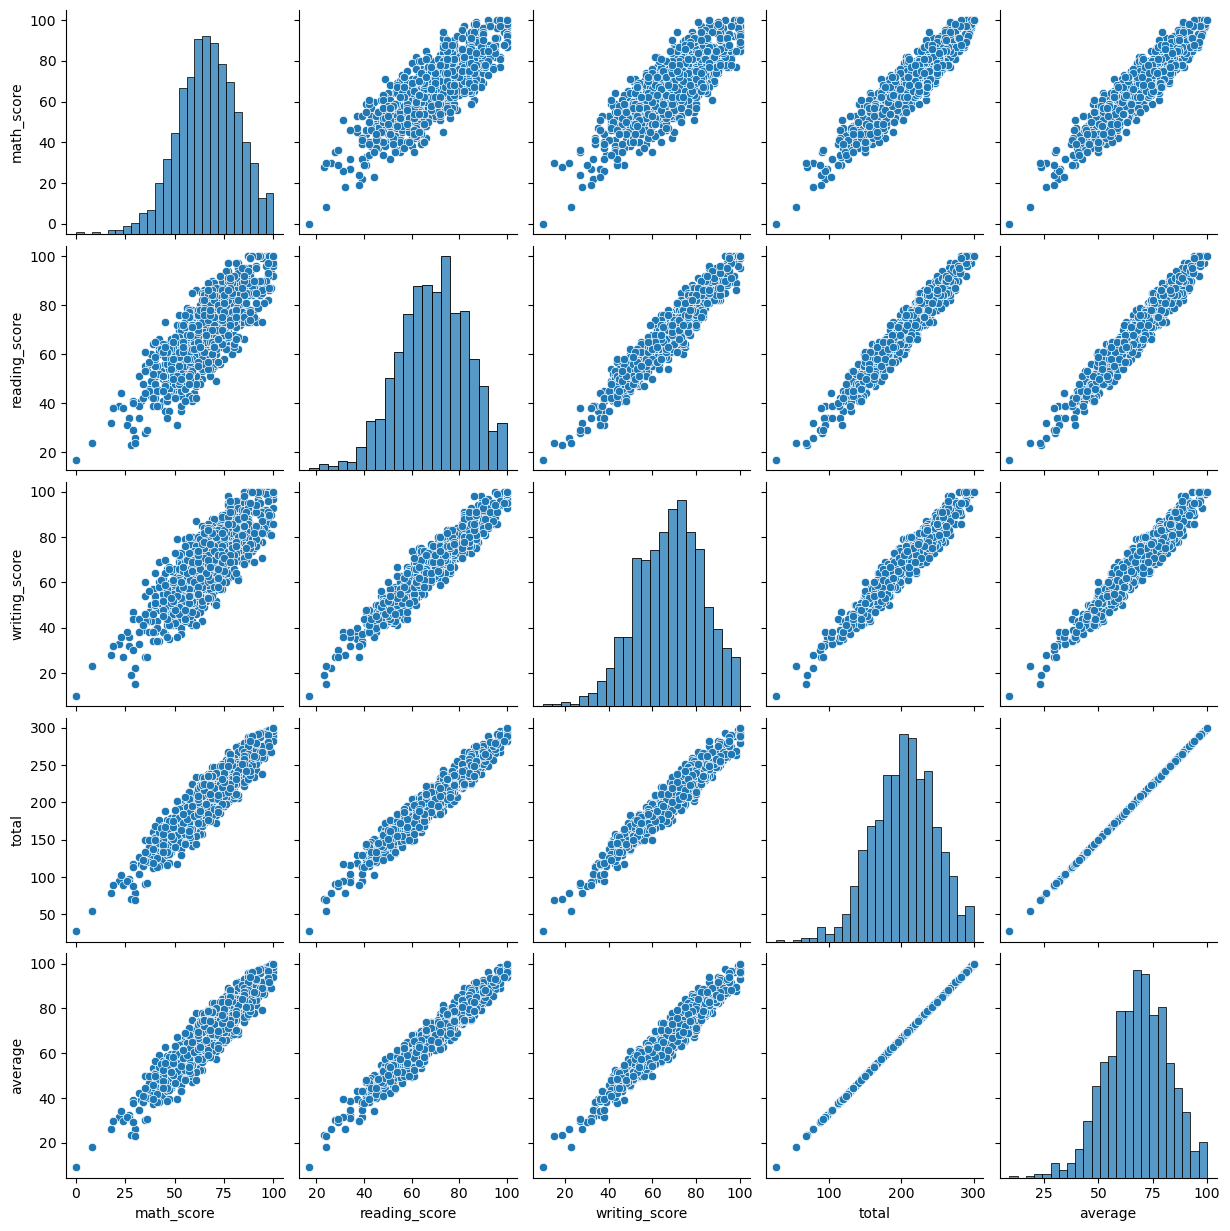

In [91]:
sns.pairplot(math)
plt.show()

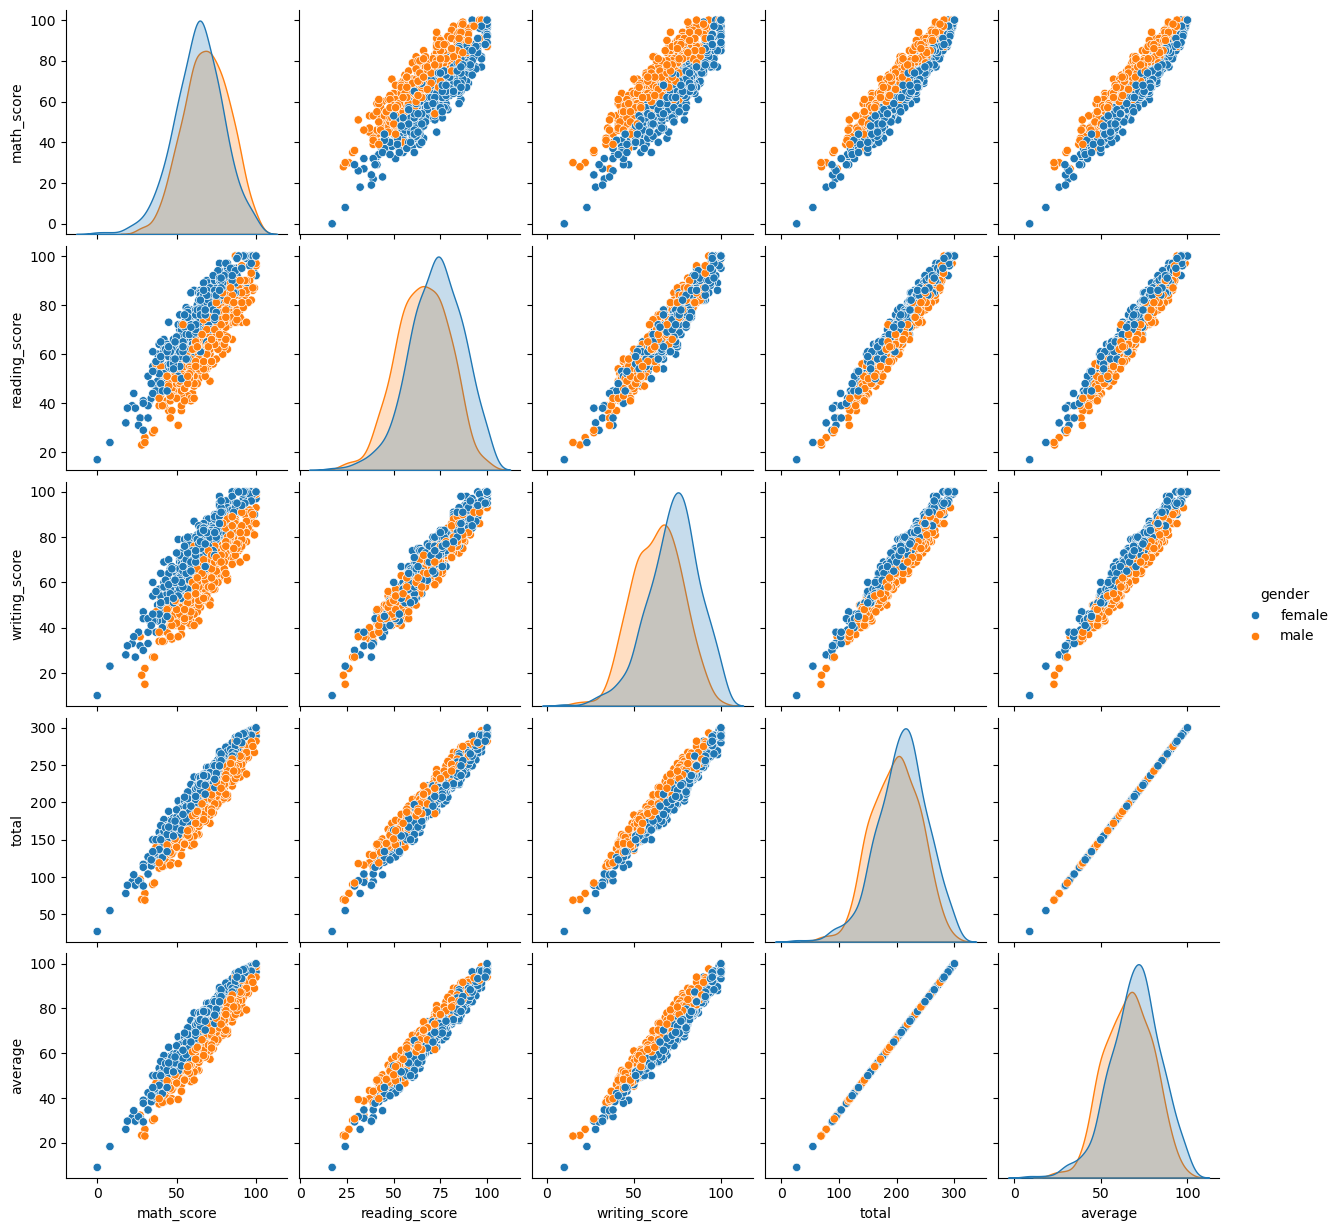

In [92]:
sns.pairplot(math, hue = 'gender')
plt.show()

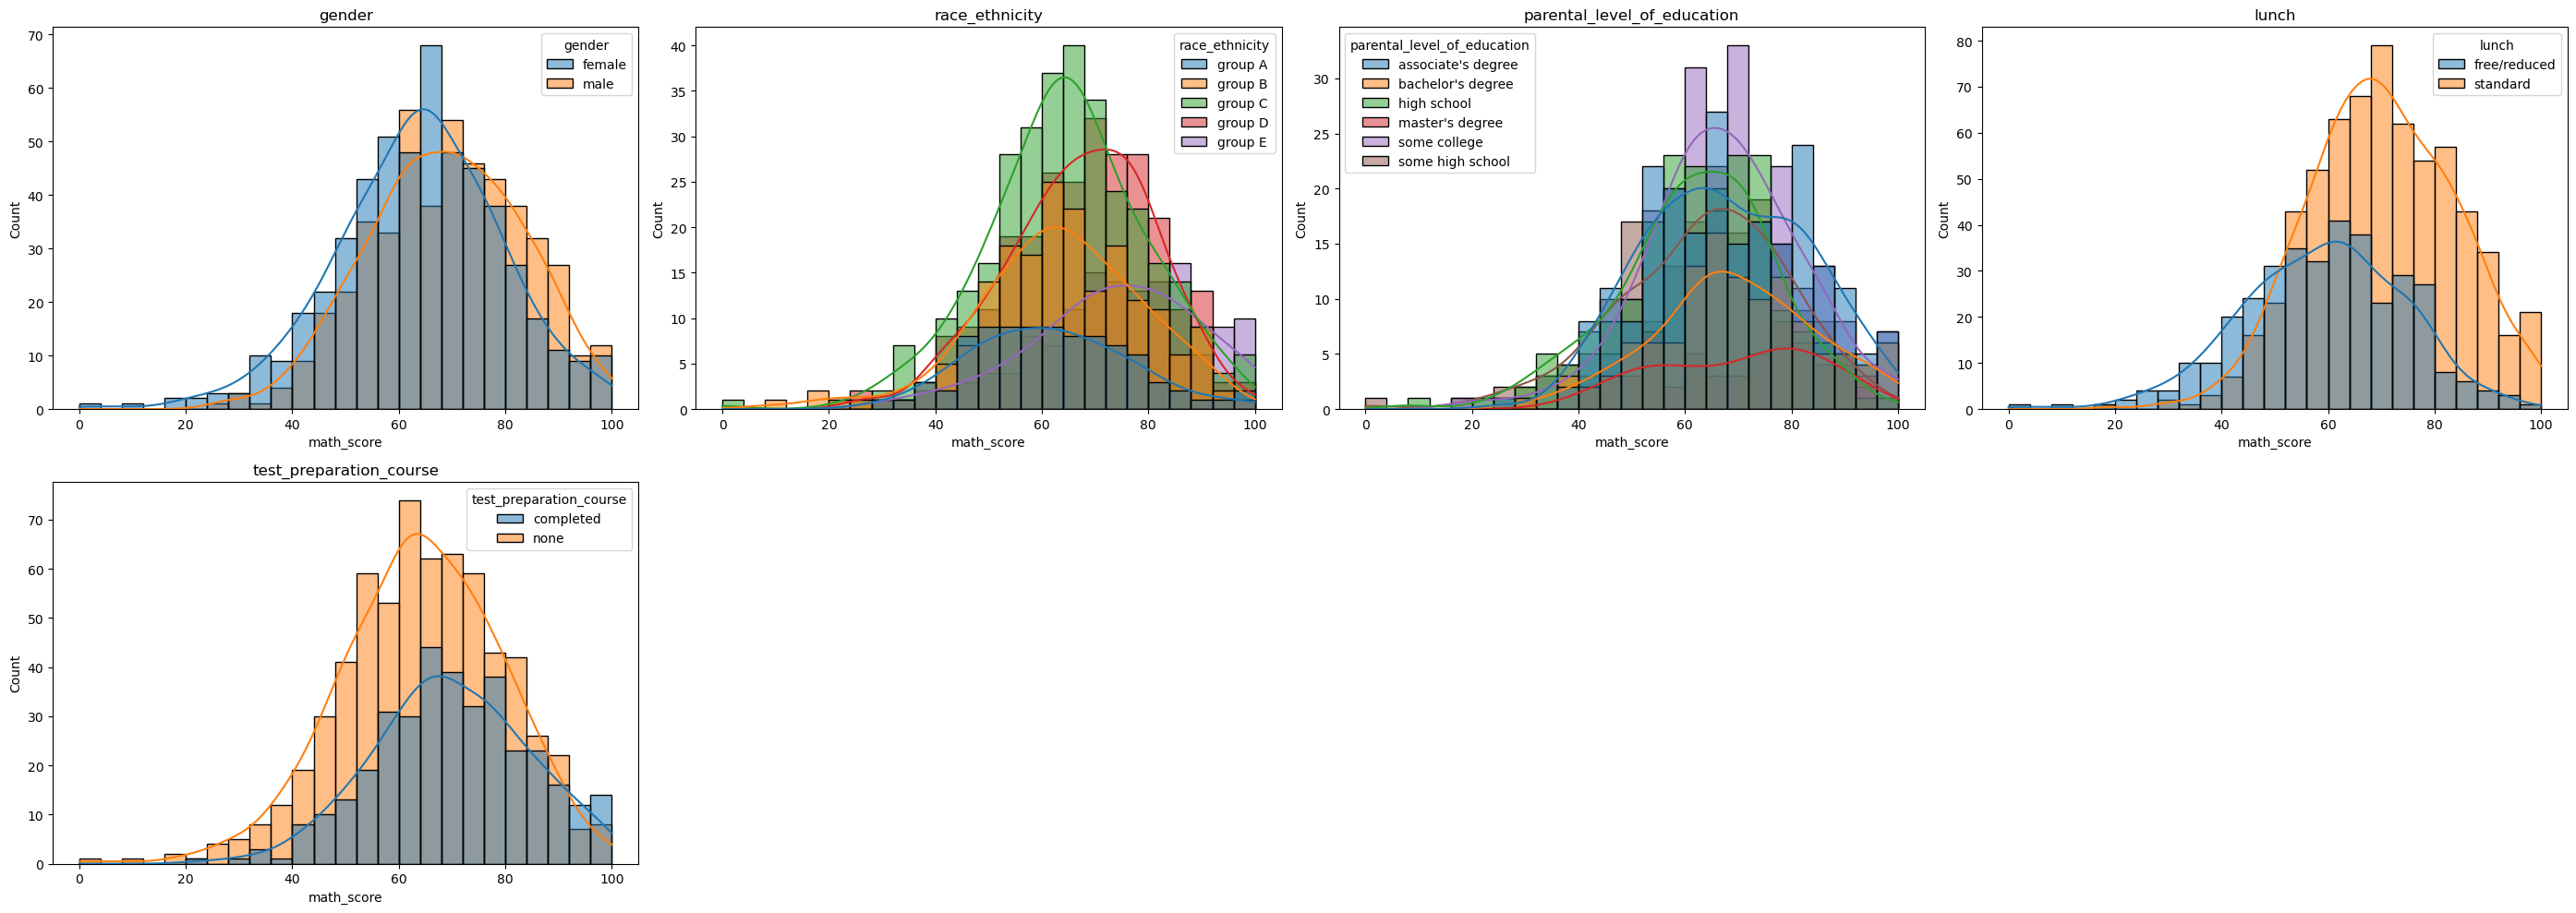

In [93]:
idsx = [(i, name) for i, name in enumerate(math.select_dtypes(include = 'category'))]
n_plots = len(idsx)
n_cols = 4
n_rows = int(np.ceil(n_plots/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols * 7, n_rows * 5))
axes = np.ravel(axes)

for ax, (i, name) in zip(axes, idsx):
    sns.histplot(data = math, x = 'math_score', hue = name, kde = True, ax = ax)
    ax.set_title(name)

for ax in axes[n_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

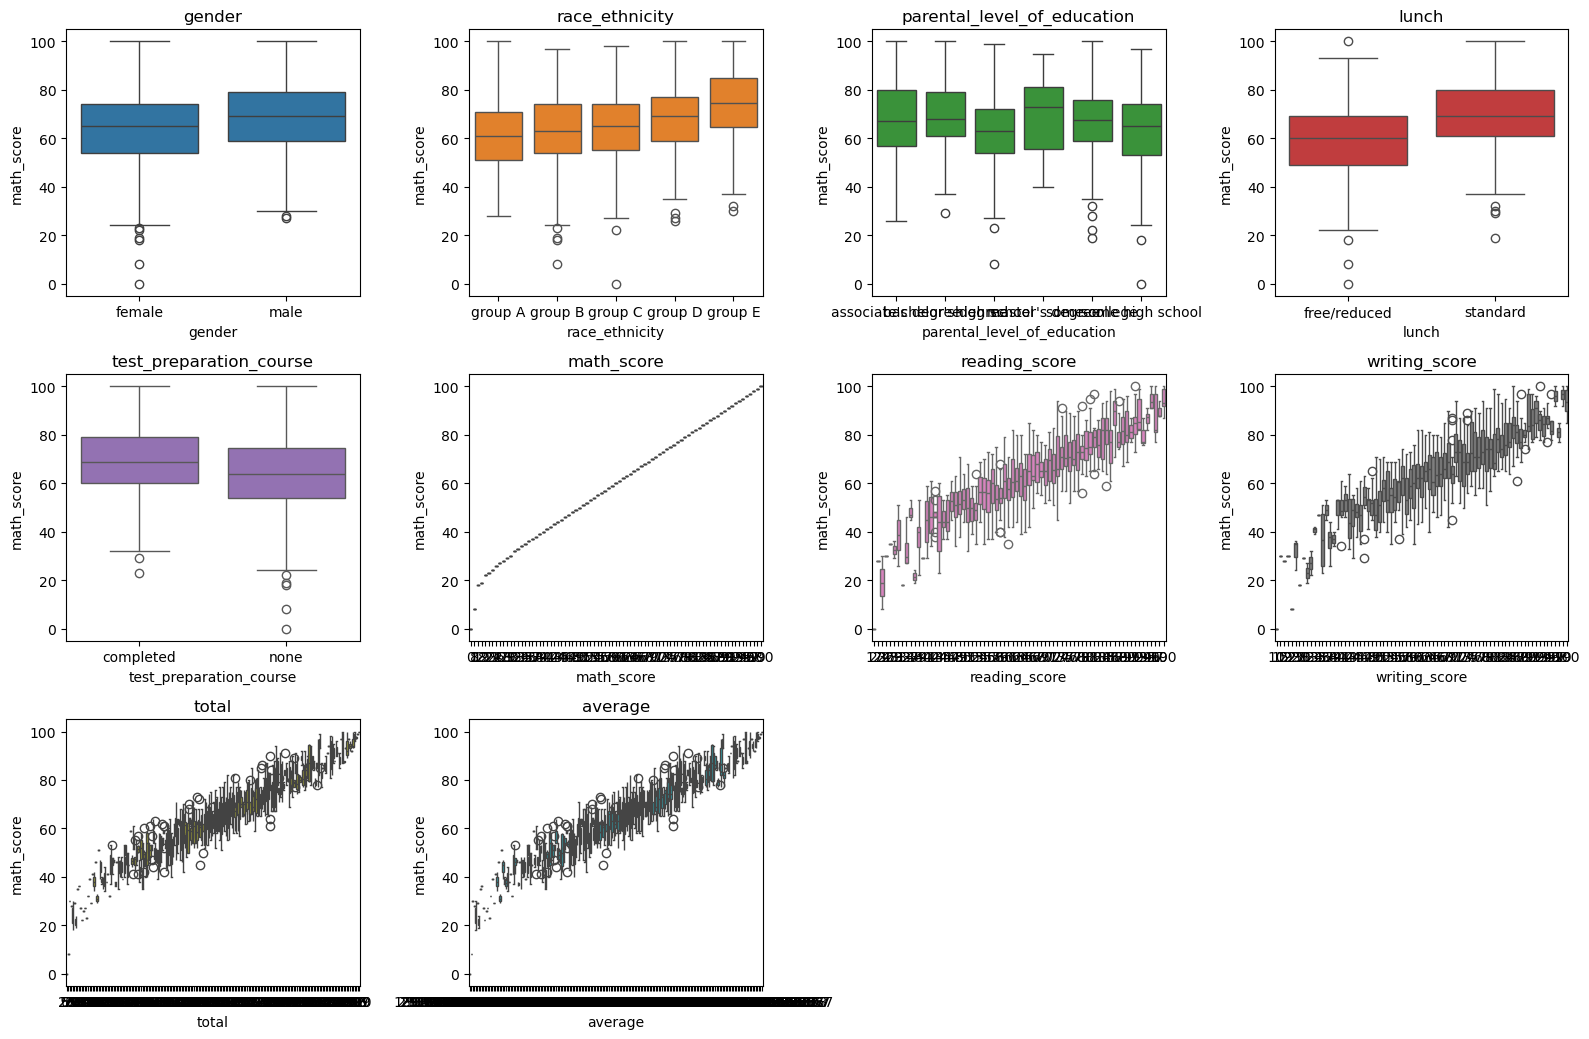

In [94]:
idsx = [(i, name) for i, name in enumerate(math.columns)]
n_plots = len(idsx)
n_cols = 4 
n_rows = int(np.ceil(n_plots/n_cols))

palette = sns.color_palette('tab10', n_plots)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols * 4, n_rows * 3.5))
axes = np.ravel(axes)

for ax, (i, name), color in zip(axes, idsx, palette):
    sns.boxplot(data = math, x = name, y = 'math_score', ax = ax, color = color)
    ax.set_title(name)

for ax in axes[n_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [95]:
math_mod = smf.ols('math_score~writing_score+reading_score+C(test_preparation_course)+C(lunch)+C(parental_level_of_education)+C(race_ethnicity)+C(gender)', data = math).fit()
print(math_mod.summary())

                            OLS Regression Results                            
Dep. Variable:             math_score   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     500.3
Date:                Thu, 08 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:18:15   Log-Likelihood:                -3090.7
No. Observations:                1000   AIC:                             6211.
Df Residuals:                     985   BIC:                             6285.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [96]:
print(anova_lm(math_mod, type = 2))

                                   df         sum_sq        mean_sq  \
C(test_preparation_course)        1.0    7253.160232    7253.160232   
C(lunch)                          1.0   28776.698009   28776.698009   
C(parental_level_of_education)    5.0    7484.247455    1496.849491   
C(race_ethnicity)                 4.0    8857.488936    2214.372234   
C(gender)                         1.0    6147.862107    6147.862107   
writing_score                     1.0  141721.537730  141721.537730   
reading_score                     1.0    1128.933991    1128.933991   
Residual                        985.0   28319.150539      28.750407   

                                          F         PR(>F)  
C(test_preparation_course)       252.280266   9.451785e-51  
C(lunch)                        1000.914470  3.760444e-152  
C(parental_level_of_education)    52.063594   5.543237e-48  
C(race_ethnicity)                 77.020554   7.321544e-57  
C(gender)                        213.835657   5.697216e

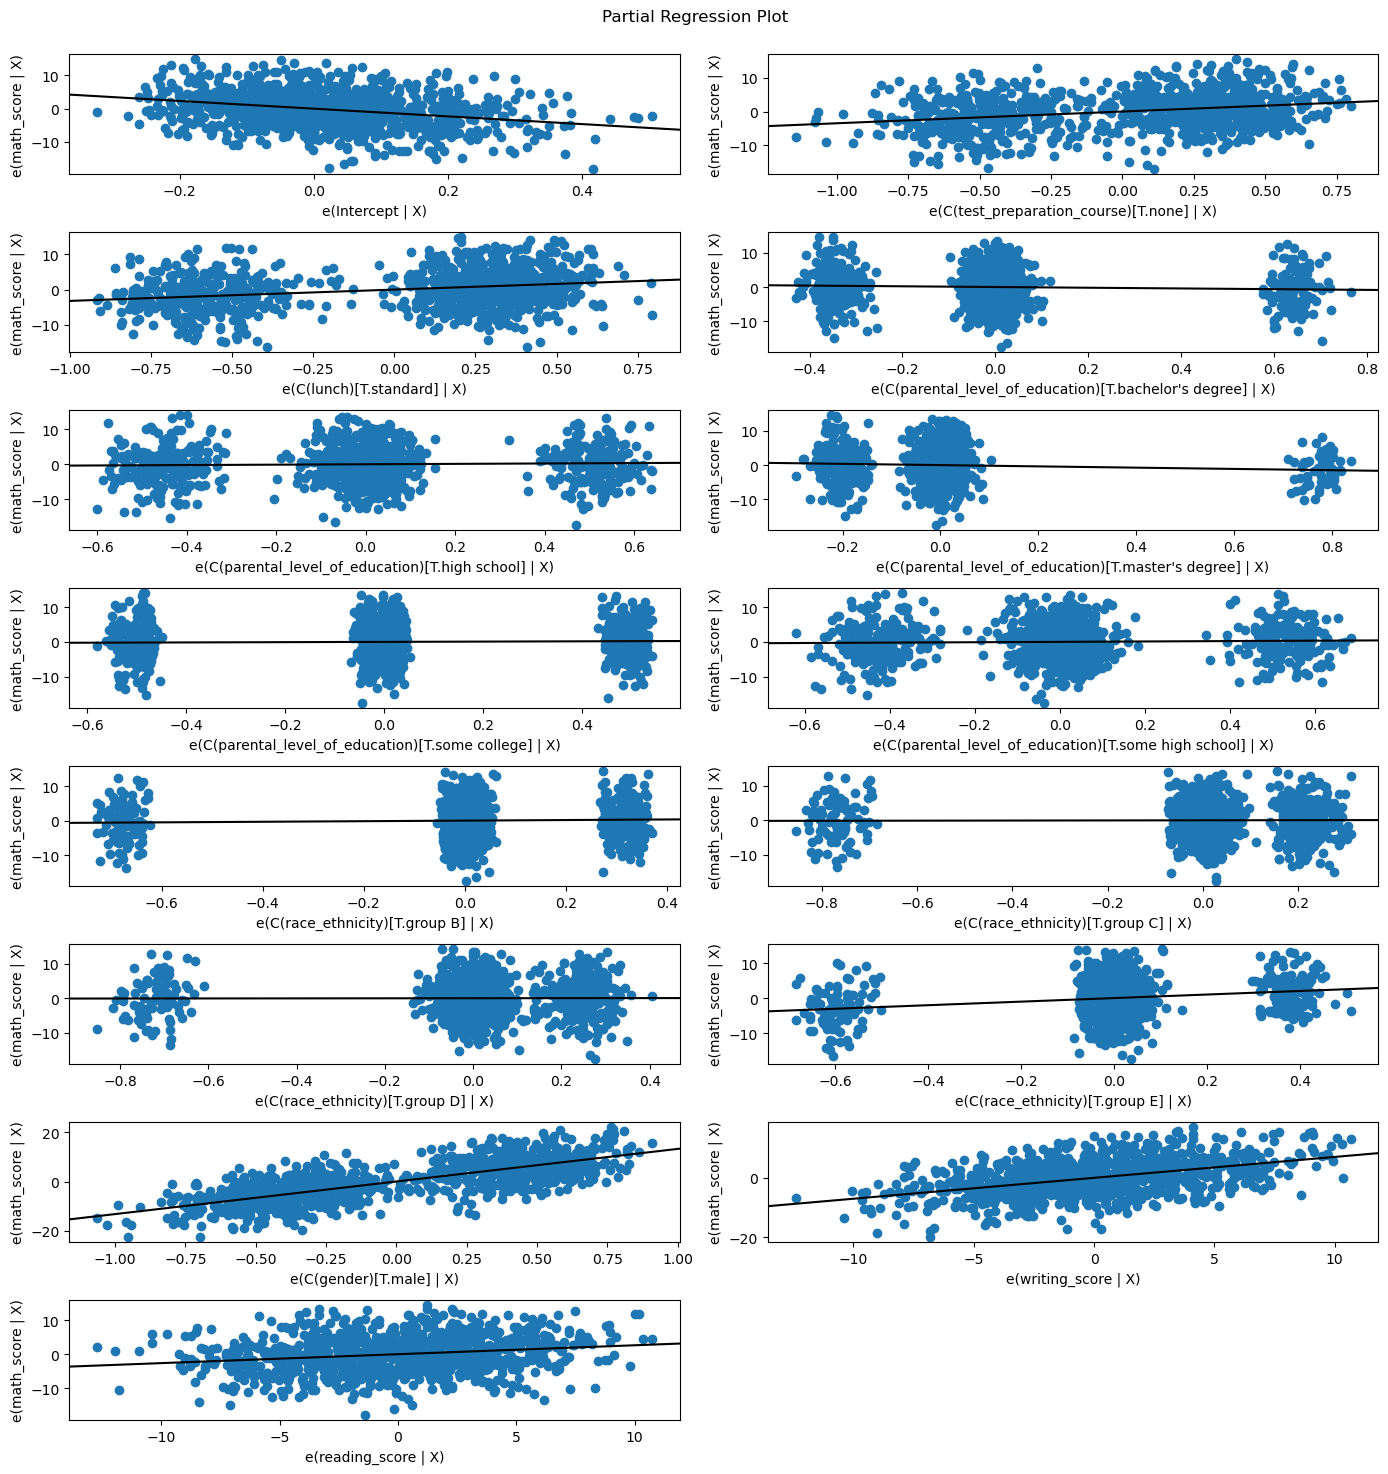

In [97]:
fig = sm.graphics.plot_partregress_grid(math_mod, fig = plt.figure(figsize = (14, 15)))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

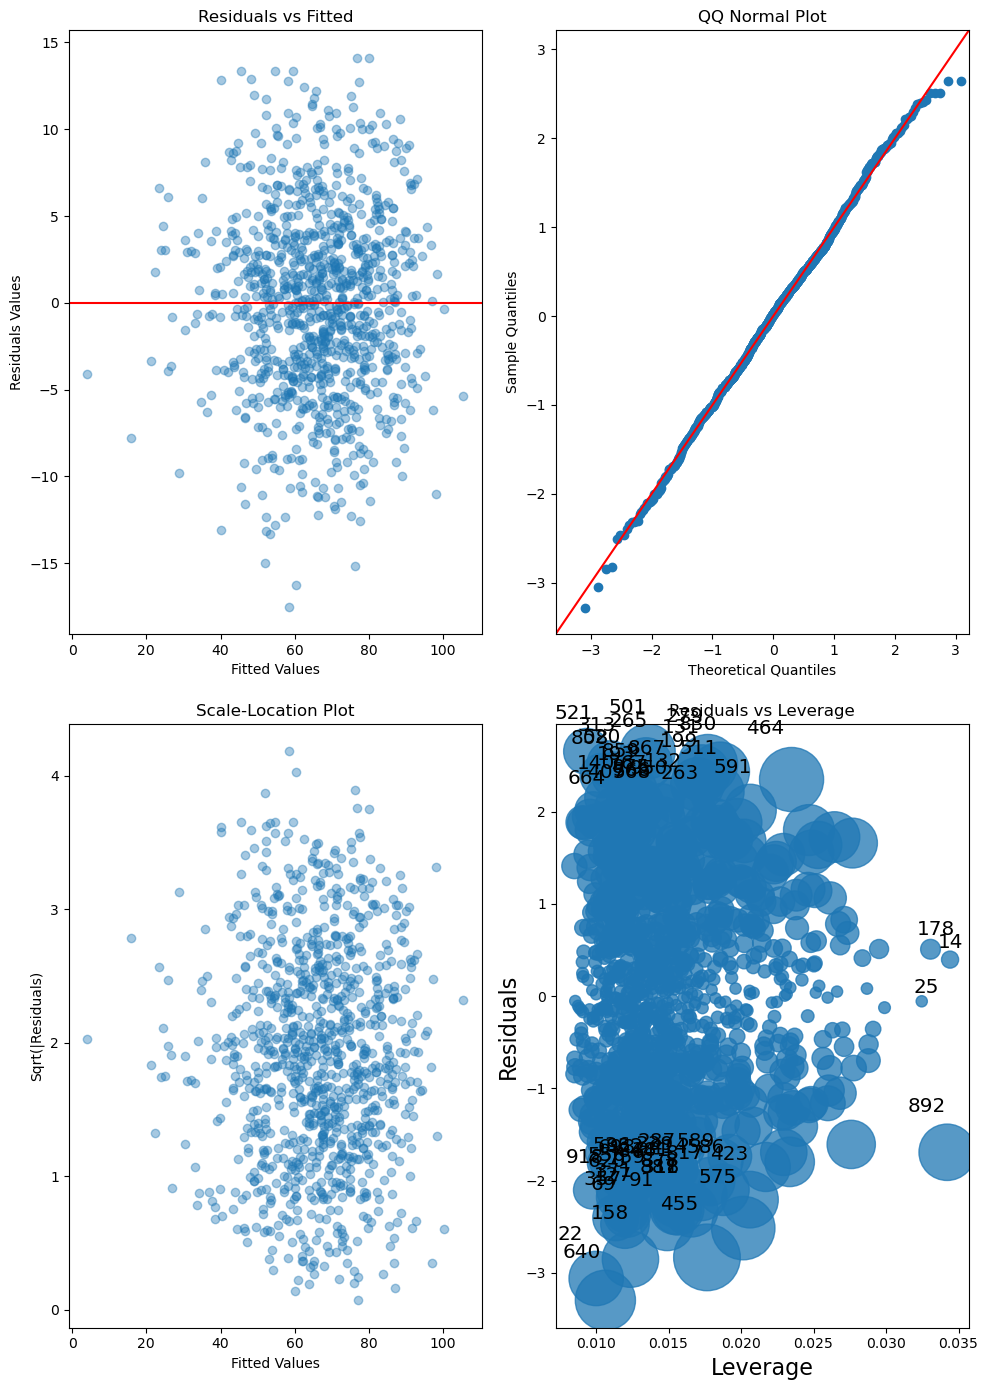

In [98]:
fig, axes = plt.subplots(2,2, figsize = (10, 14))

axes[0,0].scatter(math_mod.fittedvalues, math_mod.resid, alpha = 0.4)
axes[0,0].axhline(0, color = 'red')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals Values")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(math_mod.get_influence().resid_studentized_internal, line = '45', ax = axes[0,1])
axes[0,1].set_title("QQ Normal Plot")
axes[1,0].scatter(math_mod.fittedvalues, np.sqrt(np.abs(math_mod.resid)), alpha = 0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals)")
axes[1,0].set_title("Scale-Location Plot")
sm.graphics.influence_plot(math_mod, criterion = 'cooks', ax = axes[1,1])
axes[1,1].set_xlabel("Leverage")
axes[1,1].set_ylabel("Residuals")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show

<F test: F=3.5010946110360086, p=0.0075564277494815, df_denom=981, df_num=4>
<F test: F=0.7184029081282199, p=0.48778605021402643, df_denom=983, df_num=2>


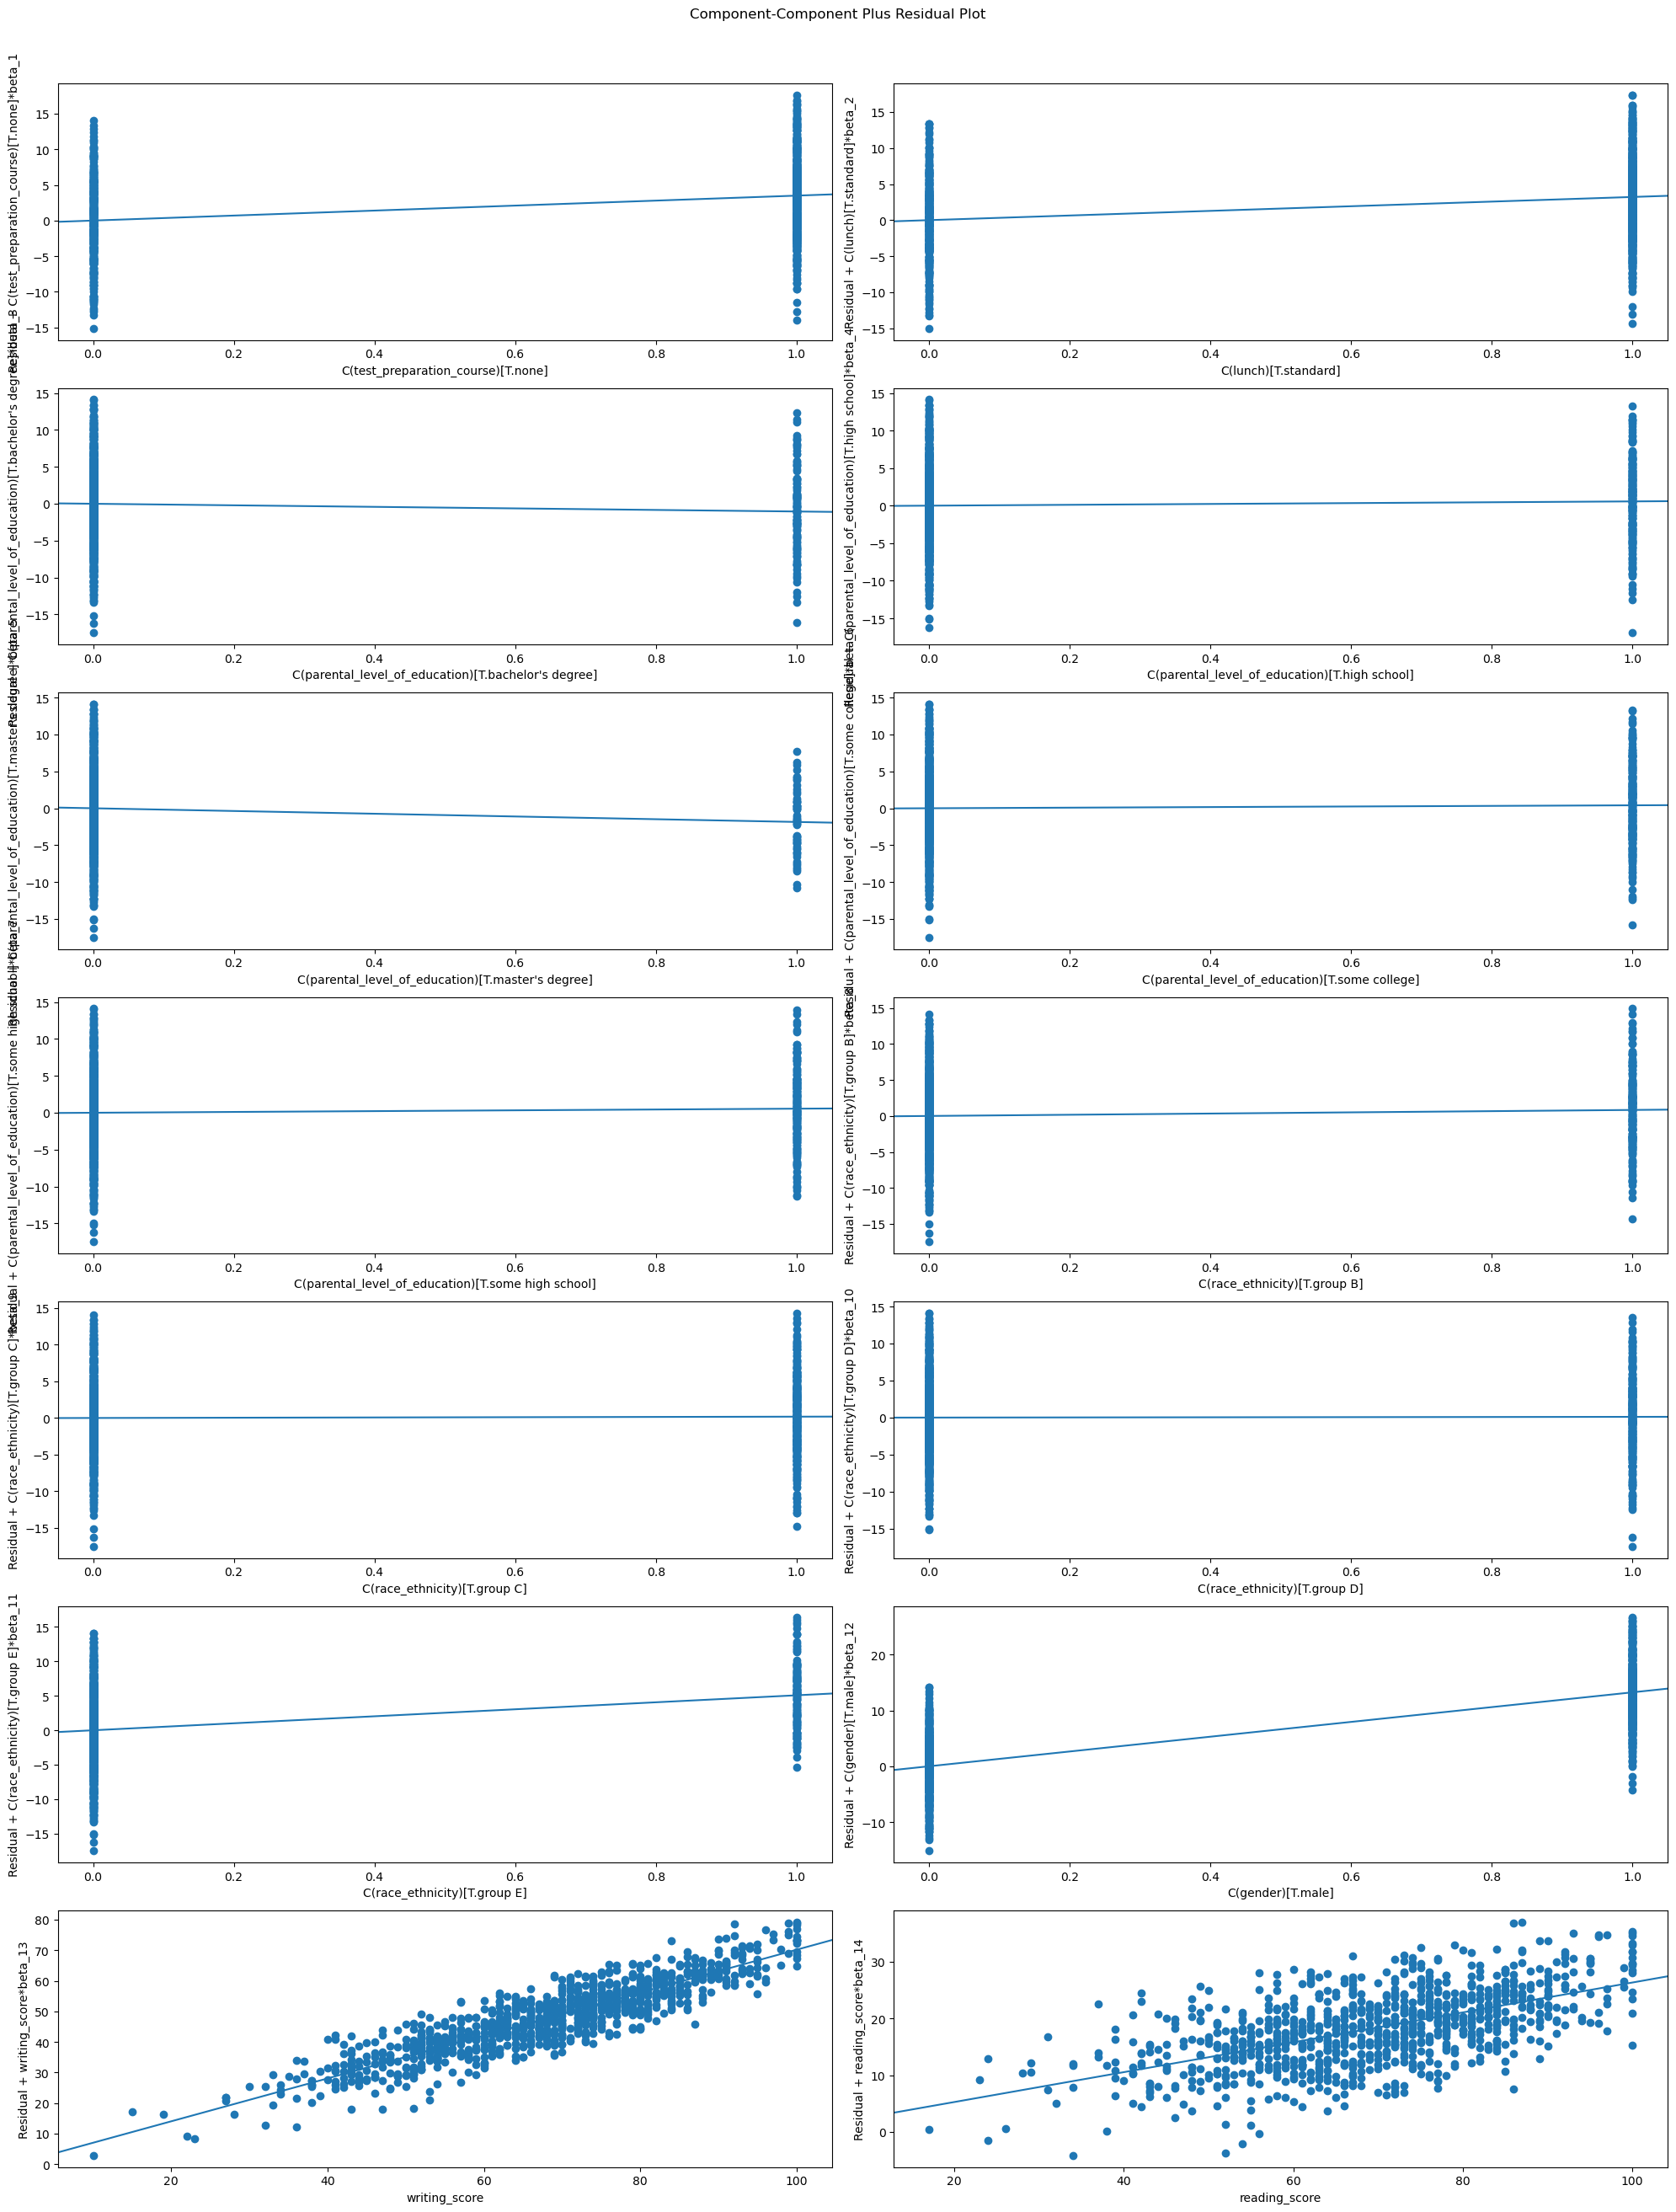

<Figure size 640x480 with 0 Axes>

In [99]:
fig = sm.graphics.plot_ccpr_grid(math_mod, fig = plt.figure(figsize = (20, 30)))
plt.figure()

print(linear_reset(math_mod, power = [2, 3], test_type = 'exog', use_f = True))
print(linear_reset(math_mod, power = [2, 3], test_type = 'fitted', use_f = True))

In [100]:
math_modbp = bp_test(math_mod.resid, math_mod.model.exog)

labels = ['BP statistic', 'BP p-value', 'f-value', 'f p-value']

for lab, stat in zip(labels, math_modbp):
    print(f'{lab} :, {stat}')

BP statistic :, 16.442365149380358
BP p-value :, 0.28711228623699897
f-value :, 1.176176964860791
f p-value :, 0.28785128160247764


In [101]:
X = math_mod.model.exog 
vif = pd.DataFrame({"Variables": math_mod.model.exog_names,
                    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]})

print(vif[vif["VIF"] >= 10])

        Variables        VIF
0       Intercept  53.895324
13  writing_score  15.197227
14  reading_score  13.098439


In [102]:
rstudent = OLSInfluence(math_mod).resid_studentized_external
df = math_mod.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_test = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_test = outlier_test.sort_values('Bonferri p-value', ascending = False).head(10)
print(outlier_test)

     rstudent  unadjusted p-value  Bonferri p-value
0    1.167774            0.243181               1.0
671 -0.625812            0.531583               1.0
658 -1.031413            0.302600               1.0
659 -0.189003            0.850129               1.0
660 -0.604484            0.545661               1.0
661  0.436432            0.662619               1.0
662 -0.846166            0.397666               1.0
663  0.741070            0.458827               1.0
664  2.018067            0.043855               1.0
665  0.557128            0.577566               1.0


In [103]:
print(math_mod.get_influence().summary_frame()[['hat_diag', 'cooks_d', 'standard_resid']].sort_values('cooks_d', ascending = False))

     hat_diag       cooks_d  standard_resid
455  0.017651  9.542643e-03       -2.822479
464  0.023484  8.805316e-03        2.343540
575  0.020151  8.624508e-03       -2.508097
640  0.010644  7.722099e-03       -3.281163
279  0.017709  7.559030e-03        2.507863
..        ...           ...             ...
702  0.023022  4.092726e-08        0.005104
264  0.010695  4.078520e-08        0.007523
260  0.012611  3.916509e-08        0.006782
818  0.012747  1.192203e-08        0.003722
687  0.012882  7.139750e-10       -0.000906

[1000 rows x 3 columns]


In [104]:
y = math['math_score']
x = math.drop(columns = ['math_score', 'total', 'average'])

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2 


num_feats = x.select_dtypes(exclude = 'category').columns.tolist()
cat_feats = x.select_dtypes(include = 'category').columns.tolist()

numeric_pipe = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = 'mean')),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = 'most_frequent')),
    ("oneshot", OneHotEncoder(handle_unknown = "ignore"))
])

preprocess = ColumnTransformer(
    transformers = [
        ("num", numeric_pipe, num_feats),
        ("cat", categorical_pipe, cat_feats)
    ],
    remainder = "drop"
)

model_grids = [
    (ElasticNet(max_iter = 20000), 
     {'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 
      'model__l1_ratio': np.arange(0.05, 1.05, 0.05)}),
    
    (RandomForestRegressor(), 
     {"model__n_estimators": [200, 500], 
      "model__max_depth": [None, 5, 10], 
      "model__min_samples_split": [2, 5]}),
    
    (KNeighborsRegressor(), 
     {"model__n_neighbors": [3, 5, 7, 11], 
      "model__weights": ["uniform", "distance"]}),
    
    (AdaBoostRegressor(), 
     {"model__n_estimators": [100, 300, 600], 
      "model__learning_rate": [0.01, 0.05, 0.1, 0.2], 
      "model__loss": ["linear", "square", "exponential"]}),
    
    (XGBRegressor(
        random_state = 0,
        objective = "reg:squarederror",
        tree_method = "hist",
        n_jobs = -1
    ),
    {"model__n_estimators": [100, 300, 600],
     "model__max_depth": [3, 5, 8],
     "model__learning_rate": [0.01, 0.05, 0.1],
     "model__subsample": [0.8, 1.0],
     "model__colsample_bytree": [0.8, 1.0],
     "model__min_child_weight": [1, 5],
     "model__reg_alpha": [0.0, 0.1, 1.0],
     "model__reg_lambda": [1.0, 5.0, 10.0]}),

     (CatBoostRegressor(
         random_seed = 0,
         loss_function = 'RMSE',
         verbose = 0,
         allow_writing_files = False
     ),
     {"model__iterations": [500, 1000],
      "model__depth": [4, 6, 8, 10],
      "model__learning_rate": [0.01, 0.05, 0.1],
      "model__l2_leaf_reg": [1, 3, 10],
      "model__subsample": [0.8, 1.0]}
     )

                      
]

In [ ]:
results = []
best_searches = []

for model, grid in model_grids:
    pipe = Pipeline(steps = [
        ("preprocess", preprocess),
        ("model", model)
    ])

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = grid, 
        cv = 5, 
        scoring = 'r2',
        n_jobs = -1,
        error_score = "raise"
    )
    gs.fit(x_train, y_train)

    y_pred_test = gs.best_estimator_.predict(x_test)
    test_mae, test_rmse, test_r2 = metrics(y_test, y_pred_test)

    results.append({
        "model": type(model).__name__,
        "cv_r2": gs.best_score_,
        "best_params": gs.best_params_,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2 
        })
    best_searches.append(gs)
    results_df = pd.DataFrame(results).sort_values("test_r2", ascending = False)
print(results_df)

In [124]:
best_gs = max(best_searches, key = lambda s: s.best_score_)
best_model = best_gs.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['reading_score',
                                                   'writing_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oneshot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'race_ethnicity',
                                                   'parental_level_of_education',
                                                   'lunch',
                                                   'test_preparation_course'])])),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=np.float64(0.05),
                            max_iter=20000))])